O dataset escolhido possui 1000 áudios de 30 segundos de diferentes músicas e 10 gêneros musicais. Cada gênero possui 100 músicas. Utilizamos esse dataset para extrair características dos áudios e conseguir identificar o gênero musical a partir dessas características.

In [2]:
import pandas as pd
import numpy as np
import seaborn
import os
import random
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Pré-processamento


Aqui separamos o nosso dataset, que eram 1000 áudios de 30 segundos, em 10000 áudios de 3 segundos para extrair as características de maneira mais precisa.

In [14]:
# Função utilizada para dividir 1 audio de 30s em 10 audios de 3s
def split_audio(y, segment_duration, sr = 22050):
    
    segment_samples = int(segment_duration * sr)
    num_segments = len(y) // segment_samples

    segments = []

    for i in range(num_segments):
        start_sample = i * segment_samples
        end_sample = start_sample + segment_samples
        segment = y[start_sample:end_sample]
        segments.append(segment)

    return np.array(segments)

# Seleção de features

Aqui foi realizado o teste do Qui Quadrado para identificar as melhores features. Utilizamos o CSV de features disponibilizado no próprio dataset para identificar as melhores para extração. Foi utilizado apenas para agilizar o processo de seleção, mas todas features usadas foram extraídas após isso.

In [3]:
# Função utilizada separadamente para escolher as melhores features utilizando o .csv do dataset
def best_features():
    # leitura do csv
    data = pd.read_csv('./Data/features_3_sec.csv')
    data = data.iloc[0:, 1:] 
    data.head()

    # separação dos dados dos resultados
    Y_CSV = data['label']
    X_CSV = data.loc[:, data.columns != 'label']

    # normalizando os dados
    scaler = MinMaxScaler()
    scaler.fit(X_CSV)
    X_CSV = scaler.transform(X_CSV)
    X_CSV = np.array(X_CSV)

    # pegando os nomes das features
    columns = list(data.loc[:, data.columns])
    columns.pop()
    columns.pop(0)

    #teste do chi quadrado para analisar quais sao as melhores features
    bestfeatures = SelectKBest(score_func=chi2, k=20)
    fit = bestfeatures.fit(X_CSV,Y_CSV)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.nlargest(20,'Score'))

In [4]:
best_features()

                      Specs       Score
16                    tempo  526.439781
4    spectral_centroid_mean  502.167020
9               rolloff_var  360.281351
6   spectral_bandwidth_mean  319.648157
3                   rms_var  302.204508
10  zero_crossing_rate_mean  292.496271
5     spectral_centroid_var  280.626324
7    spectral_bandwidth_var  254.724507
1           chroma_stft_var  233.578560
11   zero_crossing_rate_var  200.581536
14            perceptr_mean  188.376750
12             harmony_mean  175.927468
31               mfcc8_mean  174.095320
29               mfcc7_mean  172.933256
20                mfcc2_var  162.046391
27               mfcc6_mean  150.204701
8              rolloff_mean  145.002460
18                mfcc1_var  140.497141
24                mfcc4_var  130.616102
25               mfcc5_mean  115.326513


# Extração de features

Função realizada para extrair cada feature desejada de um áudio e retornar um vetor com cada feature.

In [15]:
# Função utilizada para extrair as features de cada audio
def extract_features(y, sr):
    features = []

    # Fast Fourier Transform
    fft = np.fft.fft(y)
    features.append(np.mean(np.abs(fft)))
    features.append(np.var(np.abs(fft)))

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
    features.append(tempo)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(spectral_centroid.mean())
    features.append(spectral_centroid.var())

    # Rolloff
    spec_roll=librosa.feature.spectral_rolloff(y=y,sr=sr)
    features.append(spec_roll.mean())
    features.append(spec_roll.var())

    # Spectral Bandwith
    spec_band=librosa.feature.spectral_bandwidth(y=y,sr=sr)
    features.append(spec_band.mean())
    features.append(spec_band.var())

    # Root Mean Square Energy
    RMSEn= librosa.feature.rms(y=y)
    features.append(RMSEn.mean())
    features.append(RMSEn.var())

    # Zero-Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    features.append(zero_crossing_rate.mean())
    features.append(zero_crossing_rate.var())

    # Chroma
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    features.append(chromagram.mean())
    features.append(chromagram.var())

    # Harmonics and Perceptrual 
    harmony, perceptr = librosa.effects.hpss(y=y)
    features.append(harmony.mean())
    features.append(harmony.var())
    features.append(perceptr.mean())
    features.append(perceptr.var())

    # mfccs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
    features.append(mfccs.mean())
    features.append(mfccs.var())

    return features

Aqui foi feito a extração de features de cada áudio e foi selecionado 400 áudios aleatórios de cada gênero musical (totalizando 4000)

In [16]:
# Carregar e Dividir Arquivos de Áudio e Extrair Features

X = []
Y = []
aux = []
 
N_SAMPLE_GENRE = 400
directory = './Data/genres/';
genres = os.listdir(directory)

# for para cada gênero
for genre in os.listdir(directory):
    aux = []
    genre_path = directory+genre
    # for para cada arquivo de audio
    for audio_file in os.listdir(genre_path):
        audio_path = genre_path+'/'+audio_file
        y, sr = librosa.load(audio_path, sr=22050)

        # Dividir audio de 30s em 10 audios  de 3s
        aux2 = split_audio(y, 3)
        for i in aux2:
            aux.append(i)

    # Escolher  400 audios aleatorios de um gênero
    random.shuffle(aux)
    aux = aux[:N_SAMPLE_GENRE]
    for i in aux:
        X.append(extract_features(i, sr))
    Y = Y + ([genre]*N_SAMPLE_GENRE)

Normalização entre 0 e 1

In [17]:
# Normalizar as features

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X = np.array(X)
Y= np.array(Y)

# Modelo

Não precisa rodar essa função, ela foi utilizada para identificar os hiperparâmetros, encontrados uma vez, não se faz necessário procurar novamente.

In [19]:
# Função utilizada separadamente para descobrir os melhores hiperparâmetros para serem usados na modelo Random Forest
def best_param():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    params = {'n_estimators': [100, 500, 1000],
                'bootstrap': [False, True],
                'max_depth': [10, 50, 100],
                'max_features': ['sqrt', 'log2', None],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [1, 2, 4]
                }

    RF_grid_search = GridSearchCV(RandomForestClassifier(), params, cv=5)
    RF_grid_search.fit(X_train, Y_train)

    RF_grid_search.best_params_

Na célula abaixo o modelo foi executado com os parâmetros econtrados. Utilizamos a técnica de cross validation por meio do KFold para ter um resultado mais preciso.

In [20]:
# Treinando o modelo Random Forest utilizando kFold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, bootstrap=False, max_depth=50, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)

accuracy = []
aux = np.zeros((10,10))
aux_pred = []
aux_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    rf_clf.fit(X_train, Y_train)

    Y_pred = rf_clf.predict(X_test)

    aux_pred.extend(Y_pred)
    aux_test.extend(Y_test)
    
    accuracy.append(rf_clf.score(X_test, Y_test))

    # Somar as matrizes de confusão de cada teste
    cm = confusion_matrix(Y_test, Y_pred, labels=genres)
    for i in range(len(cm)):   
        for j in range(len(cm[0])):
            aux[i][j] = aux[i][j] + cm[i][j]

# Resultados

Aqui visualizamos o desempenho do classificador.

In [21]:
# Exibir Acurácia e Classification Report

print("Accuracy: ", accuracy)
print("Accuracy Mean: ", np.mean(accuracy))

classification_rep = classification_report(aux_pred, aux_test)
print(f"\nClassification Report:\n{classification_rep}")

Accuracy:  [0.77875, 0.78625, 0.79, 0.78625, 0.795]
Accuracy Mean:  0.78725

Classification Report:
              precision    recall  f1-score   support

       blues       0.77      0.75      0.76       407
   classical       0.94      0.90      0.92       416
     country       0.78      0.65      0.71       475
       disco       0.74      0.75      0.74       397
      hiphop       0.78      0.84      0.81       370
        jazz       0.83      0.80      0.81       418
       metal       0.89      0.83      0.86       430
         pop       0.78      0.86      0.82       362
      reggae       0.77      0.76      0.77       402
        rock       0.60      0.74      0.66       323

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



Para entender melhor, foi utilizada uma confusion matrix para exibir os resultados individuais. Vale ressaltar que a matriz exibida é o resultado de 5 testes somados.

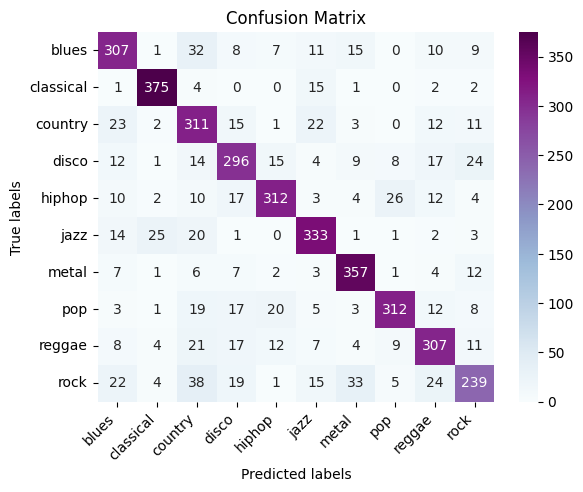

In [22]:
# Exibir Confusion Matrix

ax = plt.subplot()
seaborn.heatmap(aux, cmap="BuPu", annot=True, fmt='g', ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0, ha="right")
ax.xaxis.set_ticklabels(genres) 
ax.yaxis.set_ticklabels(genres)

plt.show()

Com os dados limitados, conseguimos uma precisão de 78% para um problema relativamente complexo, mas ao rodar o código com todos os dados obtivemos uma precisão de 85%.

![image](./Data/best_scores.jpg)

![image](./Data/best_cm.jpg)